<a href="https://colab.research.google.com/github/nuvard/kern_segmentation/blob/master/transfer_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Baseline for transfer-learning

In [0]:
%%capture

from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch 
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from torchvision import transforms

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

from __future__ import print_function, division
import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from torchvision.transforms import RandomVerticalFlip, RandomCrop

In [0]:
DEVICE = torch.device("cuda")

In [0]:
def test(device: str):
    torch.ones(1,2,3).to(device)

test(DEVICE)

In [0]:
import random
random.seed(42)

##Подготовка данных

### Загрузка таблиц

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = '/content/gdrive/My Drive/ kern/'

Все данные

In [0]:
data = pd.read_csv(path+'data.csv')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
data.head()


Folder       Id   Field  ...       Carbonate         Ruin       Saturation
0  Unload1  1000000  Field6  ...  не карбонатный  не разрушен  нефтенасыщенные
1  Unload1  1000001  Field6  ...  не карбонатный  не разрушен  нефтенасыщенные
2  Unload1  1000002  Field6  ...  не карбонатный  не разрушен  нефтенасыщенные
3  Unload1  1000003  Field6  ...  не карбонатный  не разрушен  нефтенасыщенные
4  Unload1  1000004  Field6  ...  не карбонатный  не разрушен        не опред.

[5 rows x 18 columns]

In [0]:
data.loc[data.Id==1000000,]

Folder       Id   Field  ...         Carbonate         Ruin       Saturation
0     Unload1  1000000  Field6  ...    не карбонатный  не разрушен  нефтенасыщенные
1414  Unload2  1000000  Field4  ...  слабокарбонатный  не разрушен        не опред.

[2 rows x 18 columns]

Мой диск не вмещает весь датасет, так что пока я буду работать только с первой скважиной.

Здесь я хочу отделить фото разных типов, чтобы натренировать две сетки - по одной на каждый тип.


In [0]:
#data = data.loc[data.Folder=='Unload1', ]


In [0]:
#data.to_csv(path+'data_1.csv')

Данные из первой скважины, разделённые на ДС и УФ

In [0]:
data_uf = pd.read_csv(path+'data_uf.csv', index_col=0)
data_dc = pd.read_csv(path+'data_dc.csv', index_col=0)

In [0]:
data_uf = data.loc[data['PhotoType']=='УФ',]
data_dc = data.loc[data['PhotoType']=='ДС',]


In [0]:
data_dc.shape

(2620, 18)

In [0]:
data_uf.shape

(2619, 18)

In [9]:
data_dc.tail()

Folder       Id   Field  ...               Ruin  Saturation  class
6404  Unload2  1004996  Field2  ...  частично разрушен   не опред.      1
6406  Unload2  1004998  Field2  ...  частично разрушен   не опред.      1
6408  Unload2  1005000  Field2  ...  частично разрушен   не опред.      1
6410  Unload2  1005002  Field2  ...  частично разрушен   не опред.      1
6412  Unload2  1005004  Field2  ...  частично разрушен   не опред.      1

[5 rows x 19 columns]

In [0]:
data_uf.tail()

Folder       Id   Field  ...       Carbonate               Ruin  Saturation
6405  Unload2  1004997  Field2  ...  не карбонатный  частично разрушен   не опред.
6407  Unload2  1004999  Field2  ...  не карбонатный  частично разрушен   не опред.
6409  Unload2  1005001  Field2  ...  не карбонатный  частично разрушен   не опред.
6411  Unload2  1005003  Field2  ...  не карбонатный  частично разрушен   не опред.
6413  Unload2  1005005  Field2  ...  не карбонатный  частично разрушен   не опред.

[5 rows x 18 columns]

### Переопределение классов

Нам нужны не все классы, а только некоторые. Пока я подготовлю словари для переименования классов. 

In [0]:
satur_dict = {'не опред.': 'unknown', 'нефтенасыщенные': 'oil','битуминозный':'oil', 'продукт':'oil', 'пятнисто нефтенасыщенные': 'oil','слабо нефтенасыщенные':'oil' }

In [0]:
satur_int_dict = {'oil':0, 'unknown':1}

In [0]:
rock_dict = {"с карбонатными обломками или конкрециями": "с карб. обломками или конкрециями", \
             "пересл. кремнисто-глинистой породы и аргиллита": "пересл. кремн.-глинист. породы и аргиллитa", \
             "пересл. песчаника и глины аргиллитоподобной" : "пересл. песчаника и глины аргиллитоподобн."}

In [0]:
carbon_dict = {"не карбонатный": 'no_carbon', 'с карбонатными обломками или конкрециями': 'part_carbon', 'слабокарбонатный': 'carbon', \
               'сильнокарбонатный': 'carbon', 'среднекарбонатный':'carbon', 'пятнисто карбонатный':'part_carbon', 'с примесью':'part_carbon'}

In [0]:
ruin_dict = {"не карбонатный": 'no_carbon', 'с карбонатными обломками или конкрециями': 'part_carbon', 'слабокарбонатный': 'carbon', \
               'сильнокарбонатный': 'carbon', 'среднекарбонатный':'carbon', 'пятнисто карбонатный':'part_carbon', 'с примесью':'part_carbon'}

In [0]:
data.Carbonate.value_counts()

не карбонатный                              778
слабокарбонатный                            216
с карбонатными обломками или конкрециями    198
среднекарбонатный                            92
сильнокарбонатный                            90
с примесью                                   40
Name: Carbonate, dtype: int64

In [0]:
data.Rock.value_counts()

песчаник                                750
алевролит                               308
пересл. песчаника, алевролита и глин    168
аргиллит                                 92
песчаник глинистый                       74
алевро-аргиллит                          18
глина                                     4
Name: Rock, dtype: int64

In [0]:
data.Ruin.value_counts()

не разрушен          1172
частично разрушен     230
разрушен               12
Name: Ruin, dtype: int64

In [0]:
satur_dict

{'битуминозный': 'oil',
 'не опред.': 'unknown',
 'нефтенасыщенные': 'oil',
 'продукт': 'oil',
 'пятнисто нефтенасыщенные': 'oil',
 'слабо нефтенасыщенные': 'oil'}

Я подготовила функцию для ьыстрой замены классов.

In [0]:
def apply_class(data, column, class_dict):
  data['class']=data[column].apply(lambda x:class_dict[x] if (x in class_dict) else x)

In [0]:
apply_class(data,'Saturation', satur_dict)

In [0]:
apply_class(data_uf,'class', satur_int_dict)
apply_class(data_dc,'class', satur_int_dict)

In [0]:
#apply_class(data,'Rock', rock_dict)

In [0]:
data.head()

Folder       Id   Field  ...         Ruin       Saturation    class
0  Unload1  1000000  Field6  ...  не разрушен  нефтенасыщенные      oil
1  Unload1  1000001  Field6  ...  не разрушен  нефтенасыщенные      oil
2  Unload1  1000002  Field6  ...  не разрушен  нефтенасыщенные      oil
3  Unload1  1000003  Field6  ...  не разрушен  нефтенасыщенные      oil
4  Unload1  1000004  Field6  ...  не разрушен        не опред.  unknown

[5 rows x 19 columns]

In [0]:
data['class'].value_counts()

unknown    890
oil        524
Name: class, dtype: int64

In [0]:
data_dc = data.loc[data.PhotoType=='ДС',].reset_index(drop=True)
data_uf = data.loc[data.PhotoType!='ДС',].reset_index(drop=True)
#data_2 = data.loc[data.Folder=='Unload2', ]

In [0]:
data_dc.to_csv(path+'data_1_dc.csv')
data_uf.to_csv(path+'data_1_uf.csv')

In [0]:
data_dc.head()

Folder       Id   Field  ...         Ruin       Saturation    class
0  Unload1  1000000  Field6  ...  не разрушен  нефтенасыщенные      oil
1  Unload1  1000002  Field6  ...  не разрушен  нефтенасыщенные      oil
2  Unload1  1000004  Field6  ...  не разрушен        не опред.  unknown
3  Unload1  1000006  Field6  ...  не разрушен        не опред.  unknown
4  Unload1  1000008  Field6  ...  не разрушен        не опред.  unknown

[5 rows x 19 columns]

In [0]:
data_uf.head()

Folder       Id   Field  ...         Ruin       Saturation  class
0  Unload1  1000001  Field6  ...  не разрушен  нефтенасыщенные      0
1  Unload1  1000003  Field6  ...  не разрушен  нефтенасыщенные      0
2  Unload1  1000005  Field6  ...  не разрушен        не опред.      1
3  Unload1  1000007  Field6  ...  не разрушен        не опред.      1
4  Unload1  1000009  Field6  ...  не разрушен        не опред.      1

[5 rows x 19 columns]

### Проверка

Проверка актуальности таблицы

In [0]:

def check(data):
  to_drop = []
  for i in data.index:
    img_name=data.loc[i, 'Folder']+'/data/'+str(data.loc[i, 'Id'])+'.jpeg'

    #plt.figure()
    
    if not os.path.isfile(os.path.join(path, img_name)):
      to_drop.append(i)
      print("No image " + img_name)
    #plt.show()
  if(len(to_drop)==0):
    print ("All is OK!")
   
  return data.loc[~data.index.isin(to_drop),]  


In [0]:
data = data.loc[~data.index.isin(to_drop),]

In [24]:
temp=check(data)


All is OK!


In [0]:
to

In [0]:
check(data_uf)

All is OK!


##Создание датасета

In [0]:
from fastai.vision import pil2tensor

In [0]:
def pil2tensor(image,dtype):
    "Convert PIL style `image` array to torch style image tensor."
    a = np.asarray(image)
    if a.ndim==2 : a = np.expand_dims(a,2)
    a = np.transpose(a, (1, 0, 2))
    print(a.ndim)
    a = np.transpose(a, (2, 1, 0))
    print(a.ndim)
    return torch.from_numpy(a.astype(dtype, copy=False) )

In [0]:
import PIL
def openMultiChannelImage(fpArr):
    '''
    Open multiple images and return a single multi channel image
    '''
    mat = None
    nChannels = len(fpArr)
    for i,fp in enumerate(fpArr):
        #print('Loading: ', fp)
        img = PIL.Image.open(fp)
        chan = pil2tensor(img).float().div_(255)
        if(mat is None):
            mat = torch.zeros((nChannels,chan.shape[1],chan.shape[2]))
        mat[i,:,:]=chan
    return Image(mat)


In [0]:
v = ['0', # Object reference - not used here
       Path(path +'/'+ data_uf.loc[0, 'Folder']+'/data/'+str(data_uf.loc[1, 'Id'])+'.jpeg'),
       Path(path +'/'+ data_dc.loc[0, 'Folder']+'/data/'+str(data_dc.loc[1, 'Id'])+'.jpeg')]

ret = openMultiChannelImage(v[1:])
display(ret)
print(ret.data.shape)

TypeError: ignored

In [0]:
class KernDataset(Dataset):
    """Kern dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.labels_path = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #print(csv_file)
        img_name = os.path.join(self.root_dir,
                                self.data.loc[idx, 'Folder']+'/data/'+str(self.data.loc[idx, 'Id'])+'.jpeg')
        #print(img_name)
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        
        label = self.data.loc[idx, 'class']
        #sample = {'image': image, 'class_name': label}
        return DatasetItem(image=image, label=label, id=idx, path=img_name)

Заготовка на будущее?

In [0]:
'''
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, class_name = sample['image'], sample['class_name']

        h = image.shape[0]
        new_h  = self.output_size[0]
        new_w = image.shape[1]

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'class_name': class_name}

      
class RandomHorizontalFlip(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, class_name = sample['image'], sample['class_name']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

'''

'\nclass RandomCrop(object):\n    """Crop randomly the image in a sample.\n\n    Args:\n        output_size (tuple or int): Desired output size. If int, square crop\n            is made.\n    """\n\n    def __init__(self, output_size):\n        assert isinstance(output_size, (int, tuple))\n        if isinstance(output_size, int):\n            self.output_size = (output_size, output_size)\n        else:\n            assert len(output_size) == 2\n            self.output_size = output_size\n\n    def __call__(self, sample):\n        image, class_name = sample[\'image\'], sample[\'class_name\']\n\n        h = image.shape[0]\n        new_h  = self.output_size[0]\n        new_w = image.shape[1]\n\n        top = np.random.randint(0, h - new_h)\n        left = np.random.randint(0, w - new_w)\n\n        image = image[top: top + new_h,\n                      left: left + new_w]\n\n        return {\'image\': image, \'class_name\': class_name}\n\n      \nclass RandomHorizontalFlip(object):\n    ""

In [0]:
Transform = Callable[[Image.Image], Image.Image]


@dataclass()
class ItemsBatch:
    images: torch.Tensor
    labels: torch.Tensor
    ids: List[int]
    paths: List[Path]
    items: List["DatasetItem"]


@dataclass()
class DatasetItem:
    image: Union[torch.Tensor, Image.Image]
    label: int
    id: int
    path: Path

    @classmethod
    def collate(cls, items: Sequence["DatasetItem"]) -> ItemsBatch:
        if not isinstance(items, list):
            items = list(items)
            #print(default_collate([item.label for item in items]))
        return ItemsBatch(
            images=default_collate([item.image for item in items]),
            
            labels=default_collate([item.label for item in items]),
            ids=[item.id for item in items],
            paths=[item.path for item in items],
            items=items,
        )

In [0]:
def show_batch_image(image_batch, batch_size=4, name='out.png'):
    """
    Show a sample grid image which contains some sample of test set result
    :param image_batch: The output batch of test set
    :return: PIL image of all images of the input batch
    """

    to_pil =  transforms.ToPILImage()
    fs = []
    for i in range(batch_size):
        img = to_pil(image_batch.images[i].cpu())
        fs.append(img)
    x, y = fs[0].size
    ncol = int(np.ceil(np.sqrt(batch_size)))
    nrow = int(np.ceil(np.sqrt(batch_size)))
    cvs = Image.new('RGB', (x * ncol, y * nrow))
    for i in range(len(fs)):
        px, py = x * int(i / nrow), y * (i % nrow)
        cvs.paste((fs[i]), (px, py))
    print(name)
    cvs.save(name, format='png')
    #cvs.show()
    plt.imshow(np.asarray(cvs))


Делю датасет на трейн и тест

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(data_uf)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


In [0]:
transform = transforms.Compose(
    [
        transforms.RandomRotation((5)),
        transforms.RandomResizedCrop((128,128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

dataset_uf = KernDataset(csv_file=path+'data_1_uf.csv',
                                    root_dir=path, transform=transform)

dataset_dc = KernDataset(csv_file=path+'data_1_dc.csv',
                                    root_dir=path, transform=transform)

train_size = int(0.8 * len(dataset_uf))
test_size = len(dataset_uf) - train_size

train_dataset_uf, test_dataset_uf = torch.utils.data.random_split(dataset_uf, [train_size, test_size])
train_dataset_dc, test_dataset_dc = torch.utils.data.random_split(dataset_dc, [train_size, test_size])

train_loader_uf = torch.utils.data.DataLoader(
    train_dataset_uf,
    batch_size=64,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4
)

train_loader_dc = torch.utils.data.DataLoader(
    train_dataset_dc,
    batch_size=64,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4
)

test_loader_uf = torch.utils.data.DataLoader(
    test_dataset_uf,
    batch_size=64,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4
)

test_loader_dc = torch.utils.data.DataLoader(
    test_dataset_dc,
    batch_size=64,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4
)



Проверка, правильно ли считываются картинки

out.png


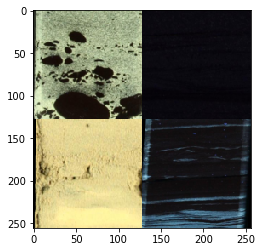

In [0]:
show_batch_image(next(iter(train_loader_uf)))


out.png


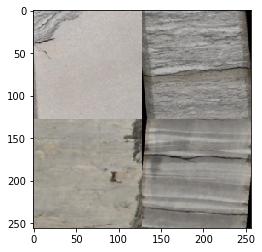

In [0]:
show_batch_image(next(iter(train_loader_dc)))

In [0]:
(next(iter(train_loader_dc)).labels)

tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

## Обучение модели 


In [0]:
from tqdm import tqdm_notebook

In [0]:
def train(model, device, train_loader, optimizer, loss_function, epoch, writer):
    #print('begin!')
    model.train()
    model.to(device)
    correct = 0
    for batch_idx, batch_data in enumerate(tqdm(train_loader)):
        #print(type(batch_data.images))
        #print(type(batch_data.labels))
        data, target = batch_data.images.to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(
        "Train Epoch: {}  [Accuracy: ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch, 100.0 * correct / len(train_loader.dataset), loss.item()
        )
    )
    writer.add_scalar("train_loss_plot", loss.item(), global_step=epoch)
    writer.add_scalar(
        "train_accuracy_plot",
        100.0 * correct / len(train_loader.dataset),
        global_step=epoch,
    )


def test(model, device, test_loader, loss_function, epoch, writer):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(test_loader)):
            data, target = batch_data.images.to(device), batch_data.labels.to(device)
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    writer.add_scalar("test_loss_plot", test_loss, global_step=epoch)
    writer.add_scalar(
        "test_accuracy_plot",
        100.0 * correct / len(test_loader.dataset),
        global_step=epoch,
    )

In [0]:
data_uf['class'].value_counts()

1    445
0    262
Name: class, dtype: int64

Пока я создаю базовые модельки. 
Я постараюсь делать всё по гайду https://karpathy.github.io/2019/04/25/recipe/.

In [18]:
model_dc = models.resnet18(pretrained=True)
model_dc.fc = nn.Linear(512, 2)
#print(model)
#torch.nn.init.xavier_uniform_(model_dc.fc.bias)
#with torch.no_grad():
#  model_dc.fc.bias = nn.Parameter(torch.Tensor([0.5, 0.5]))
 
model_dc = model_dc.to(DEVICE)

optimizer_dc = optim.Adam(model_dc.parameters(), lr=1e-3)

loss_function = loss.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 24.7MB/s]


In [0]:
import datetime

In [0]:
model_uf = models.resnet18(pretrained=True)
model_uf.fc = nn.Linear(512, 2)
#print(model)
#torch.nn.init.xavier_uniform_(model.fc.bias)
with torch.no_grad():
  model_uf.fc.bias = nn.Parameter(torch.Tensor([0, 0]))
 
model_uf = model_uf.to(DEVICE)
#model_dc = model_dc.to(DEVICE)

optimizer_uf = optim.Adam(model_uf.parameters(), lr=1e-3)

loss_function = loss.CrossEntropyLoss()

In [0]:
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
log_dir = 'logs/tensorboard/'
test_log_dir = 'logs/tensorboard/test/' + current_time

In [0]:
-np.log(1/2.0)

0.6931471805599453

Я проверяю, насколько хорошо инициализирована сетка. Пока я не нашла, как правильно инициализировать сдвиг для кросс-энтропии, собираюсь прочитать [ALL YOU NEED IS A GOOD INIT](https://arxiv.org/pdf/1511.06422.pdf), если ничего не придет в голову, спрошу в чате или при личной встрече.


In [0]:
TENSORBOARD_TAG = 'verify_loss'
writer = SummaryWriter(train_log_dir + '/' + TENSORBOARD_TAG)
test(model_dc, DEVICE, test_loader_dc, loss_function,-1, writer)


Test set: Average loss: 0.0152, Accuracy: 73/142 (51%)



Сейчас я обучу две сети: отдельно для дневного света и ультрафиолета. 

Далее нужно: 
1. обучить ансамбль для этих двух сеток 
2. обучить ансамбль на 20 сеток (по 3 канала на каждую)
3. обучить сетку с 6 входами
4. обучить сетку с 6 входами и сверткой на 3 канала на входе

Что-то ещё...

Посмотрю кеггл-кернелы с соревнований, посвящённых снимкам из космоса, может, будут ещё идеи.

*Не забыть:*
Проверить, как ведет себя трансформация на парных фотографиях, подготовить способ одинаково их трансформировать.


In [25]:
TENSORBOARD_TAG = 'together_run'

for epoch in range(20):
    writer_dc = SummaryWriter('runs/dc')
    writer_uf = SummaryWriter('runs/uf')
    print('-------------')
    print('DL classifier')
    train(model_dc, DEVICE, train_loader_dc, optimizer_dc, loss_function, epoch, writer_dc)
    test(model_dc, DEVICE, test_loader_dc, loss_function, epoch, writer_dc)
    print('-------------')
    print('UF classifier')
    
    train(model_uf, DEVICE, train_loader_uf, optimizer_uf, loss_function, epoch, writer_uf)
    test(model_uf, DEVICE, test_loader_uf, loss_function, epoch, writer_uf)
    
    
    writer_dc.close()
    writer_uf.close()

-------------
DL classifier


Train Epoch: 0  [Accuracy: (83%)]	Loss: 0.089297



Test set: Average loss: 0.0076, Accuracy: 516/642 (80%)

-------------
UF classifier


Train Epoch: 0  [Accuracy: (86%)]	Loss: 0.294687



Test set: Average loss: 0.0050, Accuracy: 568/642 (88%)

-------------
DL classifier


Train Epoch: 1  [Accuracy: (87%)]	Loss: 0.582469



Test set: Average loss: 0.0058, Accuracy: 557/642 (87%)

-------------
UF classifier


Train Epoch: 1  [Accuracy: (89%)]	Loss: 0.786379



Test set: Average loss: 0.0058, Accuracy: 568/642 (88%)

-------------
DL classifier


Train Epoch: 2  [Accuracy: (89%)]	Loss: 0.039433



Test set: Average loss: 0.0054, Accuracy: 559/642 (87%)

-------------
UF classifier


Train Epoch: 2  [Accuracy: (90%)]	Loss: 0.066310



Test set: Average loss: 0.0077, Accuracy: 569/642 (89%)

-------------
DL classifier


Train Epoch: 3  [Accuracy: (90%)]	Loss: 0.030002



Test set: Average loss: 0.0058, Accuracy: 540/642 (84%)

-------------
UF classifier


Train Epoch: 3  [Accuracy: (90%)]	Loss: 0.297394



Test set: Average loss: 0.0100, Accuracy: 482/642 (75%)

-------------
DL classifier


Train Epoch: 4  [Accuracy: (89%)]	Loss: 0.049324



Test set: Average loss: 0.0044, Accuracy: 571/642 (89%)

-------------
UF classifier


Train Epoch: 4  [Accuracy: (91%)]	Loss: 0.163289



Test set: Average loss: 0.0059, Accuracy: 563/642 (88%)

-------------
DL classifier


Train Epoch: 5  [Accuracy: (91%)]	Loss: 0.597592



Test set: Average loss: 0.0055, Accuracy: 560/642 (87%)

-------------
UF classifier


Train Epoch: 5  [Accuracy: (90%)]	Loss: 0.043963



Test set: Average loss: 0.0059, Accuracy: 564/642 (88%)

-------------
DL classifier


Train Epoch: 6  [Accuracy: (87%)]	Loss: 0.413574



Test set: Average loss: 0.0050, Accuracy: 557/642 (87%)

-------------
UF classifier


Train Epoch: 6  [Accuracy: (90%)]	Loss: 0.247029



Test set: Average loss: 0.0057, Accuracy: 555/642 (86%)

-------------
DL classifier


Train Epoch: 7  [Accuracy: (89%)]	Loss: 0.606810



Test set: Average loss: 0.0055, Accuracy: 547/642 (85%)

-------------
UF classifier


Train Epoch: 7  [Accuracy: (90%)]	Loss: 0.482606


KeyboardInterrupt: ignored

In [0]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
TENSORBOARD_TAG = 'first_run_uf'
for epoch in range(20):
    writer = SummaryWriter(train_log_dir + '/' + TENSORBOARD_TAG)
    train(model, DEVICE, train_loader_dc, optimizer, loss_function, epoch, writer)
    
    test(model, DEVICE, test_loader_dc, loss_function, epoch, writer)
    writer.close()

In [0]:
%load_ext tensorboard

In [27]:
tensorboard --logdir runs

In [0]:
tensorboard --logdir runs --port 6007

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 10, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/main.py", line 64, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.6/dist-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.6/dist-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/program.py", line 220, in main
    server = self._make_server()
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/program.py", line 299, in _make_server
    self.assets_zip_provider)
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/backend/application.py", line 160, in standard_tensorboard_wsgi
    flags, plugin_loaders, data_provider, assets_zip_provider, mul

In [0]:
ssh -X -L 16006:127.0.0.1:6007 cosmos@my_server_ip

SyntaxError: ignored